#Начальные установки и загрузка

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import sys
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import random
import time

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D,Conv2D, MaxPooling1D, MaxPooling2D,Flatten, Dense,TimeDistributed,Reshape, Dropout,BatchNormalization
from keras.layers import Activation,Conv1DTranspose,Conv2DTranspose,Input,concatenate,UpSampling2D,SimpleRNN,GRU,LSTM,Embedding,Bidirectional
from keras.utils import Sequence
from keras.models import load_model,Model
from keras.metrics import Accuracy, Precision, Recall, F1Score
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
import tensorflow as tf

from keras import backend as K

import gc

from scipy import interpolate
import seaborn as sns
from sklearn import metrics
import itertools


In [ ]:
ModelSavePath='/content/drive/MyDrive/internship/karate/models' #Путь к папке  с сохраненными моделями
win_len=96 #Ширина окна (количество кадро, которое будем одновременно подавать в сеть)
step=3 #шаг сдвига окна при обучении
batch_size=32
speed_ratios=[1,2] #[1,2,4,8] # коэфициенты имитации замедления видео для обучения
smooth_win=6  #Ширина окна сглаживания (если <2 сглаживание не производдится)
add_speed=True #добавлять в данные колонки с первой производной
discret_speed=True #В качестве скорости использовать не реальные значения, а направления (-1,0,1)
discret_speed_threshold= 5 #Отклонение скорости менее чем на это число % от минимальной будет считаться 0 скоростью
p_shift=0.1  #Вероятность того, что в серии кадров будет осуществлен случайный сдвиг фаз (аугментация)
stance_weight = 1
other_weight = 1
separate_zamah =False  #Если True, то для ударов ГЕДАН БАРАЙ (0),  УРАКЕН УЧИ (8), УЧИ УКЕ (9), СОТО УКЕ? (6) замах будет определен как отдельный класс
frame_order_ascending=True #Если False, данные в  сеть будут подаваться в обратном порядке

##Словари

In [ ]:
#Симметричные углы
symmetrical_angles= [
 ('a12_14_16','a11_13_15'),   #угол в  локтевом суставе
 ('a14_12_24','a13_11_23'),   #угол в  плечевом суставе (вертикально)
 ('a14_12_11','a13_11_12'),   #угол в  плечевом суставе (горизонтально)
 ('a24_26_28','a23_25_27'),   #угол в  коленном суставе
 ('a12_24_26','a11_23_25'),   #угол в  тазобедренном суставе
 ('a25_27_31','a26_28_32'),   #угол в  стопе
 ('a23_11_7','a24_12_8'),     #угол между линиями бедро-плечо-ухо

 #('o12_14_OY','o11_13_OY'),   #угол между линия плечо-локоть руки и OY
 #('o12_14_OX','o11_13_OX'),   #угол между линия плечо-локоть руки и OX
 #('o12_14_OZ','o11_13_OZ'),   #угол между линия плечо-локоть руки и OZ

 #('o14_16_OY','o13_15_OY'),   #угол между линия локоть-запястье руки и OY
 #('o14_16_OX','o13_15_OX'),   #угол между линия локоть-запястье руки и OX
 #('o14_16_OZ','o13_15_OZ'),   #угол между линия локоть-запястье руки и OZ

 #('o24_26_OY','o23_25_OY'),   #угол между линия бедро-колено ног и OY
 #('o24_26_OX','o23_25_OX'),   #угол между линия бедро-колено ног и OX
 #('o24_26_OZ','o23_25_OZ'),   #угол между линия бедро-колено ног и OZ

 #('o26_28_OY','o25_27_OY'),   #угол между линия колено-щиколотка ноги и OY
 #('o26_28_OX','o25_27_OX'),   #угол между линия колено-щиколотка ноги и OX
 #('o26_28_OZ','o25_27_OZ'),   #угол между линия колено-щиколотка ноги и OZ
]

In [ ]:
class_dic={
    0: 'GEDAN BARAI',
    1: 'GYAKU DZUKI',
    2: 'KIDZAMI DZUKI',
    3: 'MAWASHI DZUKI',
    4: 'MAWASHI GERI',
    5: 'MAI GERI KEAGE',
    6: 'SOTO UKE',
    7: 'URA MAWASHI GERI',
    8: 'URAKEN UCHI',
    9: 'UCHI UKE',
    10: 'OI ZUKI (No in Dataset)',
    11: 'AGE UKE (No in Dataset)',
    12: 'STANCE',
    13: 'OTHER'
    }

In [ ]:
class_weights={
    0: 1,
    1: 1,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
    8: 1,
    9: 1,
    10: 1,
    11: 1,
    12: stance_weight,
    13: other_weight
    }

In [ ]:
#N_classes = 14

# Создайте веса с правильной формой
#class_weights = np.ones((win_len, N_classes))
#class_weights[:, 12] = 1
#class_weights[:, 13] = 1

##Загрузка датасета и подключение к базе данных экспериментов

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Загрузка основного датасета

In [ ]:
#Грузим основной датасет
data_path = '/content/drive/MyDrive/internship/karate/dataset_alia/CSV'
filename = 'dataset__all_features_phase.csv'
df = pd.read_csv(os.path.join(data_path,filename)) #Основной датасет
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
0,0,0,0,0,0,0,0,0,0,0,...,0.839532,0.539682,-0.062687,0.746729,-0.545266,0.380895,0.805452,-0.073288,0.588113,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0.829084,0.549687,-0.102292,0.756509,-0.525787,0.388899,0.803362,-0.068162,0.591577,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0.826367,0.553103,-0.105799,0.763141,-0.515636,0.389532,0.804396,-0.064436,0.590588,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0.823055,0.551126,-0.137264,0.764354,-0.504475,0.401582,0.797728,-0.061704,0.599852,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0.825035,0.549418,-0.132121,0.766788,-0.502895,0.398914,0.799612,-0.060594,0.597452,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284636,0,0,0,0,0,0,0,0,0,0,...,0.906085,0.364353,-0.215073,0.894297,-0.337195,0.294164,0.793764,0.577821,0.189900,1.0
284637,0,0,0,0,0,0,0,0,0,0,...,0.906407,0.366269,-0.210411,0.891249,-0.348732,0.289934,0.802920,0.567092,0.183646,1.0
284638,0,0,0,0,0,0,0,0,0,0,...,0.904525,0.371435,-0.209451,0.890072,-0.356947,0.283480,0.806687,0.563872,0.176929,1.0
284639,0,0,0,0,0,0,0,0,0,0,...,0.903095,0.380851,-0.198425,0.885717,-0.362682,0.289772,0.811039,0.558422,0.174299,1.0


In [ ]:
def add_column (df,column_name,loc=None):
  '''
  Добавляет новый столбец в указанное место, если такого еще нет
  '''
  if column_name not in df.columns:
    if loc is None:
      loc=len(df.columns)
    df.insert(loc,column_name,np.zeros(len(df)))

def prepare_df (df):
  '''
  Выполняет необходимые преобразования датасета, например, добавление нового класса
  '''

  #Оставим только размеченные данные
  df=df[df['phase']>0]

  #Добавляем новый класс Замах в разметку
  if separate_zamah:
    add_column(df,'14',14)
    df.loc[((df['phase']==4) & ((df['1']==0) | (df['1']==8) | (df['1']==9)) ),'14']=1 #метка замаха для ударов 0,8,9
    df.loc[((df['phase']==4) & ((df['1']==0) | (df['1']==8) | (df['1']==9)) ),['0','8','9']]=0
    class_dic[14]='SWING'
  return df

#Подготовка датафрейма

In [ ]:
df=prepare_df(df)
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
0,0,0,0,0,0,0,0,0,0,0,...,0.839532,0.539682,-0.062687,0.746729,-0.545266,0.380895,0.805452,-0.073288,0.588113,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0.829084,0.549687,-0.102292,0.756509,-0.525787,0.388899,0.803362,-0.068162,0.591577,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0.826367,0.553103,-0.105799,0.763141,-0.515636,0.389532,0.804396,-0.064436,0.590588,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0.823055,0.551126,-0.137264,0.764354,-0.504475,0.401582,0.797728,-0.061704,0.599852,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0.825035,0.549418,-0.132121,0.766788,-0.502895,0.398914,0.799612,-0.060594,0.597452,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284636,0,0,0,0,0,0,0,0,0,0,...,0.906085,0.364353,-0.215073,0.894297,-0.337195,0.294164,0.793764,0.577821,0.189900,1.0
284637,0,0,0,0,0,0,0,0,0,0,...,0.906407,0.366269,-0.210411,0.891249,-0.348732,0.289934,0.802920,0.567092,0.183646,1.0
284638,0,0,0,0,0,0,0,0,0,0,...,0.904525,0.371435,-0.209451,0.890072,-0.356947,0.283480,0.806687,0.563872,0.176929,1.0
284639,0,0,0,0,0,0,0,0,0,0,...,0.903095,0.380851,-0.198425,0.885717,-0.362682,0.289772,0.811039,0.558422,0.174299,1.0


##Выбор признаков, которые будем подавать в сеть

In [ ]:
#сформируем список с названиями колонок для X и Y
column_list=list(df)
x_column_list=[x for x in column_list if (x.startswith(('a','g','o')) and  '_OZ' not in x and '_OX' not in x and  '_OY' not in x)] #в X  только данные о  cos углов (их имена начинаются на 'a','g','o')
y_column_list=[x for x in column_list if x.isdigit()] # толлько метки
print(f'В X войдут следующие колонки: {x_column_list}')
print(f'В Y войдут следующие колонки: {y_column_list}')

В X войдут следующие колонки: ['a12_14_16', 'a11_13_15', 'a14_12_24', 'a13_11_23', 'a14_12_11', 'a13_11_12', 'a24_26_28', 'a23_25_27', 'a12_24_26', 'a11_23_25', 'a25_27_31', 'a26_28_32', 'a23_11_7', 'a24_12_8', 'g12_11_28_27', 'g12_11_24_23', 'g12_11_26_25', 'g12_11_14_13', 'g12_11_16_15', 'g14_16_13_15', 'g12_14_11_13', 'g24_26_23_25', 'g26_28_25_27']
В Y войдут следующие колонки: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']


In [ ]:
#сформируем окончательный список  колонок, которые нам могут понадобится остальные удалим для экономии памяти
need_column_list=[ 'correct', 'main_folder', 'folder', 'filename', 'frame#', 'folder_cat', 'correct_cat', 'filename_cat', 'phase'] #Служебные колонки
vizual_column_list=[x for x in column_list if x.startswith(('x_','y_'))] # для визуализации
need_column_list.extend(y_column_list)
need_column_list.extend(x_column_list)
need_column_list.extend(vizual_column_list)
df=df[need_column_list]
df

,correct,main_folder,folder,filename,frame#,folder_cat,correct_cat,filename_cat,phase,0,...,x_28,y_28,x_29,y_29,x_30,y_30,x_31,y_31,x_32,y_32
0,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),0,0,0,0,1.0,0,...,0.331218,0.859000,0.472340,0.841459,0.318306,0.875136,0.520081,0.855820,0.350605,0.909742
1,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),1,0,0,0,1.0,0,...,0.331274,0.861117,0.472208,0.842373,0.317856,0.876080,0.519879,0.854984,0.350485,0.909176
2,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),2,0,0,0,1.0,0,...,0.331360,0.862314,0.472195,0.843167,0.317757,0.876620,0.519846,0.854440,0.350192,0.909110
3,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),3,0,0,0,1.0,0,...,0.331413,0.862243,0.472126,0.844075,0.317735,0.876399,0.520018,0.853493,0.348890,0.909107
4,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),4,0,0,0,1.0,0,...,0.331412,0.862217,0.471966,0.844548,0.317402,0.876261,0.520159,0.852752,0.348577,0.909360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284636,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_flip,533,0,1,479,1.0,0,...,0.425017,0.833655,0.608160,0.861945,0.430866,0.854375,0.601156,0.894158,0.393433,0.863834
284637,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_flip,534,0,1,479,1.0,0,...,0.426847,0.833515,0.608155,0.861851,0.431666,0.854004,0.601365,0.893943,0.395236,0.863627
284638,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_flip,535,0,1,479,1.0,0,...,0.427801,0.833233,0.608153,0.861681,0.432111,0.853741,0.601633,0.893903,0.397387,0.863331
284639,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_flip,536,0,1,479,1.0,0,...,0.427978,0.832918,0.607926,0.861201,0.432132,0.853586,0.602015,0.893069,0.397073,0.863105


##Зеркалирование данных

In [ ]:
def add_mirror (df):
  df_mir=df.copy()
  df_mir['filename']=df_mir['filename'].apply(lambda x: x+'_mirror')
  for pair in symmetrical_angles:
    temp = df_mir[pair[0]]
    df_mir[pair[0]] = df_mir[pair[1]]
    df_mir[pair[1]] = temp
  df=pd.concat([df,df_mir],ignore_index=True)
  return df

In [ ]:
df= add_mirror (df)

In [ ]:
df

,correct,main_folder,folder,filename,frame#,folder_cat,correct_cat,filename_cat,phase,0,...,x_28,y_28,x_29,y_29,x_30,y_30,x_31,y_31,x_32,y_32
0,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),0,0,0,0,1.0,0,...,0.331218,0.859000,0.472340,0.841459,0.318306,0.875136,0.520081,0.855820,0.350605,0.909742
1,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),1,0,0,0,1.0,0,...,0.331274,0.861117,0.472208,0.842373,0.317856,0.876080,0.519879,0.854984,0.350485,0.909176
2,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),2,0,0,0,1.0,0,...,0.331360,0.862314,0.472195,0.843167,0.317757,0.876620,0.519846,0.854440,0.350192,0.909110
3,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),3,0,0,0,1.0,0,...,0.331413,0.862243,0.472126,0.844075,0.317735,0.876399,0.520018,0.853493,0.348890,0.909107
4,right,ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ),side,Андрей ГЬЯКУ ДЗУКИ (2),4,0,0,0,1.0,0,...,0.331412,0.862217,0.471966,0.844548,0.317402,0.876261,0.520159,0.852752,0.348577,0.909360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569277,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_fl...,533,0,1,479,1.0,0,...,0.425017,0.833655,0.608160,0.861945,0.430866,0.854375,0.601156,0.894158,0.393433,0.863834
569278,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_fl...,534,0,1,479,1.0,0,...,0.426847,0.833515,0.608155,0.861851,0.431666,0.854004,0.601365,0.893943,0.395236,0.863627
569279,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_fl...,535,0,1,479,1.0,0,...,0.427801,0.833233,0.608153,0.861681,0.432111,0.853741,0.601633,0.893903,0.397387,0.863331
569280,wrong,УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ),side,Максим УЧИ УКЕ (кулак развернут не верно 2)_fl...,536,0,1,479,1.0,0,...,0.427978,0.832918,0.607926,0.861201,0.432132,0.853586,0.602015,0.893069,0.397073,0.863105


In [ ]:
#del df_mir
gc.collect()

49

In [ ]:
len(x_column_list)

23

##Разделение на тренеровочную и проверочную выборки

In [ ]:
#Посмотрим список файлов и ударов, которые есть в размеченном датасете
kick_list=np.unique(df['main_folder'])
kick_list

array(['ГЕДАН БАРАЙ (БЛОК ПЕРЕДНЕЙ РУКОЙ)',
       'ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ)',
       'КИДЗАМИ ДЗУКИ (ПРЯМОЙ УДАР ПЕРЕДНЕЙ РУКОЙ)',
       'МАВАШИ  ДЗУКИ (КРУГОВОЙ УДАР ЗАДНЕЙ РУКОЙ)',
       'МАВАШИ ГЕРИ  (КРУГОВОЙ УДАР ЗАДНЕЙ НОГОЙ)',
       'МАЙ ГЕРИ КЕАГЕ (ПРЯМОЙ УДАР ЗАДНЕЙ НОГОЙ)',
       'СОТО УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ)',
       'УРА МАВАШИ ГЕРИ (ОБРАТНЫЙ КРУГОВОЙ  УДАР ЗАДНЕЙ НОГОЙ)',
       'УРАКЕН УЧИ (КРУГОВОЙ УДАР ПЕРЕДНЕЙ РУКОЙ)',
       'УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ)'], dtype=object)

In [ ]:
total_file_list=[]
for kick in kick_list:
  file_list=np.unique(df.loc[df['main_folder']==kick,'filename'])
  print (f'для удара {kick} размечены файлы {file_list} \r\n Всего: {len(file_list)} файлов',sep=',')
  total_file_list.extend(file_list)


для удара ГЕДАН БАРАЙ (БЛОК ПЕРЕДНЕЙ РУКОЙ) размечены файлы ['Андрей ГЕДАН БАРАЙ' 'Андрей ГЕДАН БАРАЙ (2)'
 'Андрей ГЕДАН БАРАЙ (2)_flip' 'Андрей ГЕДАН БАРАЙ (2)_flip_mirror'
 'Андрей ГЕДАН БАРАЙ (2)_mirror'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)_flip'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)_flip_mirror'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)_mirror'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)_flip'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)_flip_mirror'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)_mirror'
 'Андрей ГЕДАН БАРАЙ_flip' 'Андрей ГЕДАН БАРАЙ_flip_mirror'
 'Андрей ГЕДАН БАРАЙ_mirror'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)_flip'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)_flip_mirror'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)_mirror'
 'Ан

Будет не правильным, если тренировать сеть и валидировать результаты мы будем на данных из одних и тех же файлов. Поэтому, проверять качество обучения будем на тех видеофайлах, которые сеть не видела.

Поэтому, в проверочную вборку будем выбирать не фрагменты с видео, а полностью файлы.

In [ ]:
random.seed(42)
val_files_count=len(total_file_list)//5 #20%
val_files=np.random.choice(total_file_list,size=val_files_count,replace=False)
print(f'Для Валидационной выборки выбрано {val_files_count} файлов из {len(total_file_list)}')
val_files=sorted(val_files)
for vf in val_files:
  print(vf)

Для Валидационной выборки выбрано 192 файлов из 960
Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)
Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)_flip_mirror
Андрей ГЕДАН БАРАЙ_flip_mirror
Андрей ГЕДАНБАРАЙ (кулак развернут не верно 2)_flip_mirror
Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  1)_flip
Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  1)_flip_mirror
Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  2)_flip_mirror
Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  2)_mirror
Андрей ГЬЯКУ ДЗУКИ (2)_flip
Андрей ГЬЯКУ ДЗУКИ (без поворота корпуса 2)
Андрей ГЬЯКУ ДЗУКИ (выпирают пальцы 1)_flip
Андрей ГЬЯКУ ДЗУКИ (выпирают пальцы 2)_flip_mirror
Андрей ГЬЯКУ ДЗУКИ(с низу в верх 2)
Андрей ГЬЯКУ ДЗУКИ_flip_mirror
Андрей КИДЗАМИ ДЗУКИ (кулак)_flip_mirror
Андрей КИДЗАМИ ДЗУКИ (кулак)_mirror
Андрей КИДЗАМИ ДЗУКИ (локоть 2)_mirror
Андрей МАВАШИ ГЕРИ (без какае коми 1)_flip_mirror
Андрей МАВАШИ ГЕРИ (без какае коми 2)_mirror
Андрей МАВАШИ ГЕРИ (замах чере перед 1)_flip
Андреи

In [ ]:
#Установим поле filename в качестве индекса датафрейма для увеличения скорости обработки
df=df.set_index(['filename'],drop=False)

In [ ]:
#Формируем тренеровочную и валидационную выборки
df_train=df.loc[~df.index.isin(val_files)]
df_val=df.loc[df.index.isin(val_files)]

print (f'В трененровочной выборке {len(np.unique(df_train["filename"]))} файлов')
print (f'В проверочной выборке {len(np.unique(df_val["filename"]))} файлов')

print (f'В трененровочной выборке {len(df_train)} записей')
print (f'В проверочной выборке {len(df_val)} записей')

В трененровочной выборке 768 файлов
В проверочной выборке 192 файлов
В трененровочной выборке 455391 записей
В проверочной выборке 113891 записей


#Основные функции

##Аугментация

In [ ]:
def get_slow_motion(column, ratio):
  '''
  Выполняет интерполяцию данных column и возращает последовательность в ratio раз длиннее исходного
  '''
  x=range(0,len(column))
  inter = interpolate.interp1d(x, column,kind="linear")
  x_inter=np.linspace(0,len(column)-1,num=len(column)*ratio)
  y_inter = inter(x_inter)
  return y_inter

In [ ]:
def aug_speed_long(X,Y=None,ratio=1):
  '''
  получает на вход набор углов,  имитирует случайное замедление в ratio раз, возвращает все получившиеся данные
  '''
  if ratio==1:
    return X,Y #  не уменьшаем скорость
  X=np.apply_along_axis(get_slow_motion, axis=0, arr=X,ratio=ratio)
  if Y is not None:
    Y=np.repeat(Y, ratio,axis=0)
  return X,Y


In [ ]:
#Для аугментации в датагенераторе
def aug_speed(X,Y=None,speed_ratios=[1,2,4,8],p=1):
  '''
  получает на вход набор углов,  имитирует случайное замедление в ratio раз, из получившейся последовательности возвращает случайный участок такой же длины, как и входные данные
  p  - вероятность применения трансформации
  '''
  p_trans=random.random()
  if p_trans>p:
    return X,Y # не применяем трансформацию
  ratio_index=np.random.randint(0,len(speed_ratios))
  ratio_value=speed_ratios[ratio_index]
  if ratio_value==1:
    return X,Y # не уменьшаем скорость
  result=np.apply_along_axis(get_slow_motion, axis=0, arr=X,ratio=ratio_value)
  #Получили массив в ratio раз длиннее, но мы должны вернуть данные той же размерности. Выберем случайный участок нужной длины
  source_len=len(X)
  result_len=len(result)
  begin_index=np.random.randint(0,result_len-source_len)
  X= result[begin_index:begin_index+source_len]
  if Y is not None:
    Y=np.repeat(Y, ratio_value,axis=0)
    Y=Y[begin_index:begin_index+source_len]
  return X,Y


In [ ]:
# Функция  применения скользящего окна для сглаживания 1D (1 последовательность)
def aug_smooth_column(data, window_width):
    smoothed_data = np.convolve(data, np.ones(window_width) / window_width, mode='same')
    return smoothed_data

In [ ]:
# Функция  применения скользящего окна для сглаживания 2D (несколько последовательностей)
def aug_smooth(data, window_width):
    if window_width<2:
      return data
    smoothed_data=np.apply_along_axis(aug_smooth_column, axis=0, arr=data,window_width=window_width)
    return smoothed_data

In [ ]:
#Добавление столбцов с первой производной
def aug_add_speed_data (X, discret_speed, discret_speed_threshold):
  '''
  добавляет к исходному тензору столбцы с первыми производными. Для нулевой строки первая производная =0
  discret_speed - Если True, то в качестве скоростей дискретные  значения -1;0;1
  discret_speed_threshold - % от разницы между максимальной и минимальной скоростями, в пределах которого скорость будет считаться 0
  '''
  x_d=np.diff(X,n=1,axis=0) #Получили скорости
  x_d=np.vstack([np.zeros(x_d.shape[-1]),x_d]) #Первая строка для скоростей 0

  if discret_speed:
  #Попробуем указывать направление скоростей, а не их значения
    min=np.min(np.abs(x_d))
    max=np.max(np.abs(x_d))
    threshoold = min+(max-min)/100*discret_speed_threshold

    x_d[(x_d<=threshoold) & (x_d>=-threshoold)]=0 #Для значений по модулю меньше threshoold  считаем что скорость =0
    x_d[x_d>threshoold]=1
    x_d[x_d<-threshoold]=-1
  x_res=np.hstack([X,x_d])
  return x_res

In [ ]:
def aug_random_shift (X,Y,shift_max=1,p=0.5):
  '''
  выполняет случайный сдвиг колонок на случайную величину shift вверх или вниз

  X - ndarray  2D входные данные
  Y - ndarray  2D выходные данные
  shift - максимальная величина сдвига
  p  - вероятность применения трансформации

  return -  новые X и Y ndarray со сдвигами . Количество строк (кадров) в которых меньше чем в изначальных данных на 2*shift
  '''
  def get_random_slice(column, win_len, shift_max=1):
    '''
    возвращает случайный срез данных для одной колонки длиной win_len
    '''
    shift=np.random.randint(-1*shift_max,shift_max+1)
    start_index=(len(column)-win_len)//2 + shift

    return column[start_index:start_index+win_len]

  win_len=len(X)-shift_max*2  # Количество кадров, которое мы должны вернуть
  p_trans=random.random()
  if p_trans>p:
    return X[shift_max:shift_max+win_len],Y[shift_max:shift_max+win_len] # не применяем трансформацию
  #Применяем трансфрмацию
  if add_speed:
    #только к левой половине колонок (к углам)
    x= np.apply_along_axis(get_random_slice, axis=0, arr=X[:,:X.shape[-1]//2], win_len=win_len, shift_max=shift_max)#только к левой половине колонок
    #после сдвига пересчитаем скорости (первую производную)
    x=aug_add_speed_data (x, discret_speed, discret_speed_threshold)
  else:
    #Применяем сдвиг ко всем колонкам
    x= np.apply_along_axis(get_random_slice, axis=0, arr=X, win_len=win_len, shift_max=shift_max)#только к левой половине колонок
  y=Y[shift_max:shift_max+win_len]
  return x,y

##Подготовка датасета

In [ ]:
def prepare_data(X,Y=None,speed_ratio=1,smooth_win=0,add_speed=True):
  '''
  Выполняет необходимые X и Y перед подачей в сеть
  '''

  X=np.arccos(X)/np.pi #переведем сразу в радианы и разделим на PI (номировка 0-1)
  #X,Y=aug_speed(X,Y,speed_ratios=[speed_ratio],p=1) # Возвращаем замедленный в ratio раз фрагмент такой же длины
  X,Y = aug_speed_long(X,Y,speed_ratio) # Возвращаем замедленный в ratio раз фрагмент
  X=aug_smooth(X,smooth_win) #Сглаживание данных
  if add_speed:
    X=aug_add_speed_data(X,discret_speed=discret_speed, discret_speed_threshold=discret_speed_threshold) #Добавили колонки со скоростями (первая производная)
  return X,Y

In [ ]:
def get_X_Y(df,x_columns,y_columns,speed_ratios=[1,2,4,8],smooth_win=0,add_speed=True):
  '''
  Формирует списки ndarray для входных и выходных данных для обучения. Выполняет предварительную подготовку данных.
  Каждый элемент списка представляет собой данные для одного файла
  df - с данными
  x_columns - колонки, которые войдут в X
  y_columns - колонки, которые войдут в Y

  return
  списки X и Y в виде ndarray
  '''
  file_names=np.unique(df['filename'])
  X=[]
  Y=[]
  for speed_ratio in speed_ratios:
    for file_index, file_name in  enumerate(file_names):
        file_data=df[df['filename']==file_name].sort_values('frame#',ascending=frame_order_ascending)
        #Получаем данные для X и Y
        x_data=file_data[x_columns].values
        y_data=file_data[y_columns].values
        #Перобразуем данные
        x_data,y_data=prepare_data(x_data,y_data,speed_ratio,smooth_win,add_speed)
        #Добавляем в списки
        X.append(x_data)
        Y.append(y_data)
  return X,Y


##ДатаГенератор

###Класс ДатаГенератора

In [ ]:
class TimeSeriesGenerator(Sequence):
    def __init__(
        self,
        X,           # список ndarray  Входные данные. Каждый элемент списка представляет собой данные для одного файла
        Y,           # список ndarray  Выходные данные Каждый элемент списка представляет собой данные для одного файла
        win_len,     # Длина последовательности, которую мы будем использовать в каждом батче (окно).
        batch_size,  # Размер батча.
        step=1,      # Шаг, на который сдвигается окно при генерации последовательностей.
        p_shift=0.1,  # Вероятность применения аугментации сдвига фаз
        shift_max=1,  # Максимальный сдвиг фазы
                 ):
        """
        Реализует датагенератор

        Параметры:
        - X - список ndarray  Входные данные. Каждый элемент списка представляет собой данные для одного файла
        - Y - список ndarray  Выходные данные Каждый элемент списка представляет собой данные для одного файла
        - win_len: Длина последовательности, которую мы будем использовать в каждом батче (окно).
        - batch_size: Размер батча.
        - step: Шаг, на который сдвигается окно при генерации последовательностей.
        - p_shift    Вероятность применения аугментации сдвига фаз
        - shift_max    Максимальный сдвиг фазы
        """
        self.X =X
        self.Y=Y
        self.win_len = win_len + 2*shift_max
        self.batch_size = batch_size
        self.step = step
        self.p_shift = p_shift
        self.shift_max = shift_max
        self.indices = self._generate_indices()

    def _generate_indices(self):
        """
        Генерация индексов для выбора случайных последовательностей из временных рядов.

        Returns:
        - indices: Список кортежей (индекс файла в списке X, начальный индекс ).
        """
        indices = []
        for file_index, file_data  in  enumerate(self.X):
          current_len=len(indices)
          for start_index in range(0, len(file_data) - self.win_len + 1, self.step):
            indices.append((file_index, start_index))
          #print(f'Для файла с индексом {file_index} добавлено {len(indices) - current_len} фрагментов')
        print(f'Всего Сформировано {len(indices)} фрагментов')
        return indices

    def __len__(self):
        """
        Возвращает количество батчей в генераторе.

        Returns:
        - Количество батчей.
        """
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        """
        Получение батча данных по индексу.

        Parameters:
        - index: Индекс батча.

        Returns:
        - X_batch: Входные данные батча.
        - y_batch: Выходные данные батча.
        """
        #Выбираем индексы из которых будем формировать батч
        batch_indices = np.random.choice(len(self.indices), size=self.batch_size, replace=False) #Выбрали batch_size индексов в self.indices
        batch_indices = [self.indices[i] for i in batch_indices] #Выбрали значения по индексам

        X_batch = []
        Y_batch = []

        for file_index, start_index in batch_indices:
            end_index = start_index + self.win_len
            file_data_x=self.X[file_index]
            file_data_y=self.Y[file_index]
            x_data=file_data_x[start_index:end_index]
            y_data=file_data_y[start_index:end_index]

            #Аугментация сдвиг по фазе
            x_data,y_data =aug_random_shift(x_data,y_data,self.shift_max,self.p_shift) #Случайный сдвиг фаз

            X_batch.append(x_data)
            Y_batch.append(y_data)

        return np.array(X_batch), np.array(Y_batch)


##Отображение графиков обучения и Confusion Matrix

In [ ]:
def show_charts(history,figsize=(25,8), title=None):
  '''Показывает графики истории обучения
  history - словарь из объекта history
  '''
  if history is None or len(history)==0:
    print ('Данные об истории обучения отсутствуют')
    return
  plt.figure(figsize=figsize)
  #график ошибки
  ax=plt.subplot(1,2,1)
  plt.plot(history['loss'],
         label='Ошибка на обучающем наборе')
  plt.plot(history['val_loss'],
         label='Ошибка на проверочном наборе')
  plt.legend()# Отрисовка легенды
  plt.title(title)
  ax.grid()
  plt.xlabel('Эпоха обучения')

  #графики метрик
  ax=plt.subplot(1,2,2)
  keys=list(history.keys())
  keys.remove('loss')
  keys.remove('val_loss')

  for item in keys:
    lable='тренеровочном'
    if item.startswith('val_'):
        lable='проверочном'
    plt.plot(history[item],
         label=f'Доля верных ответов на {lable} наборе {item}')
  # Отрисовка подписей осей
  plt.xlabel('Эпоха обучения')
  plt.title(title)
  ax.grid()
  plt.legend()# Отрисовка легенды
  plt.show()

In [ ]:
def show_confusion_matrix(Y_true,Y_pred):
  figsize = (8,8)
  fig, ax = plt.subplots(figsize=figsize)
  plt.title('Confusion Matrix')
  actual_classes=np.unique([Y_true,Y_pred])
  tick_labels=[class_dic[cl] for cl in class_dic if cl in actual_classes]
  cm = metrics.confusion_matrix(Y_true,Y_pred,normalize=None)
  hmap=sns.heatmap(cm, annot=True, fmt='.0f', cbar=False,
                    xticklabels=tick_labels,
                    yticklabels=tick_labels)
  plt.ylabel('Real')
  plt.xlabel('Predicted')
  plt.show()

##Генерация видео

In [ ]:
def draw_landmarks(data,frame):
  '''
  проецирует landmarks на видео

  data - DataFrame  с  координатами точек соответствующими  текущему кадру
  frame - изображение

  '''
  def calc_coordinate (data,frame,dot):
    '''
    Считает реальные ккординаты точки
    data - Serias с координатfми точек для каждого кадра
    frame - изображение
    dot  - номер точки
    '''
    x=int(data['x_'+dot].iloc[0]*frame.shape[1])
    y=int(data['y_'+dot].iloc[0]*frame.shape[0])
    return (x,y)

  def draw_line (data,frame,dot1,dot2,color=(0, 255, 0)):
    #print(f'{calc_coordinate(data,frame,dot1)} --- {calc_coordinate(data,frame,dot2)}')
    cv2.line(frame, calc_coordinate(data,frame,dot1), calc_coordinate(data,frame,dot2), color, thickness=2)
    return frame


  #тело
  frame=draw_line(data,frame,'11','12',(0, 255, 0))
  frame=draw_line(data,frame,'12','24',(0, 255, 0))
  frame=draw_line(data,frame,'24','23',(0, 255, 0))
  frame=draw_line(data,frame,'23','11',(0, 255, 0))

  #ноги
  frame=draw_line(data,frame,'23','25',(255, 255, 0))
  frame=draw_line(data,frame,'25','27',(255, 255, 0))

  frame=draw_line(data,frame,'24','26',(255, 0, 255))
  frame=draw_line(data,frame,'26','28',(255, 0, 255))

  #руки
  frame=draw_line(data,frame,'11','13',(255, 255,0))
  frame=draw_line(data,frame,'13','15',(255, 255, 0))

  frame=draw_line(data,frame,'12','14',(255, 0, 255))
  frame=draw_line(data,frame,'14','16',(255, 0, 255))
  return frame

In [ ]:
def get_dot_coord (df,dot):
  x=f'{df["x_"+str(dot)].iloc[0]:.2f}'
  y=f'{df["y_"+str(dot)].iloc[0]:.2f}'
  z=f'{df["z_"+str(dot)].iloc[0]:.2f}'
  v=f'{df["v_"+str(dot)].iloc[0]:.0f}'
  return (x,y,z,v)

def get_angle_dots(angle):
  '''
  Возвращает список точек по названию угла
  '''
  dots=angle[1:].split('_')
  return dots

def get_angle_dots_coord (df,angle):
  '''
  Возвращает строковое представление значений коодинат для точек одного угла
  '''
  dots=get_angle_dots(angle)
  Data=[]
  for dot in dots:
    if dot=='':
      continue
    koord=get_dot_coord(df,dot)
    Data.append(koord)
  return tuple(Data)

In [ ]:
DisplaySkipFrame=10

def mark_move(data,VideoPathIn, VideoPathOut,Y_data=None,frame_ratio=1,original_df=None,show_landmarks=None,drop_frame_count=0):
  '''
  маркирует каждый кадр из видео VideoPathIn, в соответствии с данными data.  Формирует новое видео  по VideoPathOut
  data - numpy массив с результатами обработки  сетью (количество кадров,количество классов)
  VideoPathIn - путь к исходному видеофайлу
  VideoPathIn - путь к итоговому видеофайлу
  Y_data - numpy массив с правильными результатами (количество кадров,количество классов)
  frame_ratio - обрабатывать каждый frame_ratio кадр (пропуск кадров) Нужно если хотим имитировать замедление видео

  drop_frame_count - сколько кадров нужно пропустить, нужно если предикт был не с 0го кадра
  '''
  cap = cv2.VideoCapture(VideoPathIn)
  if (cap.isOpened() == False):
    print("Ошибка открытия видеофайла")
    return
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print (f'Всего кадров {total_frame_count}')
  frame_size=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  #print (frame_size)
  Output = cv2.VideoWriter(VideoPathOut, cv2.VideoWriter_fourcc(*'MP4V'), fps, frame_size)
  FrameIndex=-1
  while(True): # Вывод кадров производится  в цикле
    ret, frame = cap.read()
    FrameIndex+=1
    if FrameIndex<drop_frame_count:
      continue
    FrameRatioIndex=(FrameIndex-drop_frame_count)//frame_ratio #Счетчик кадров с учетом frame_ratio
    #print(f'{FrameIndex} , {FrameRatioIndex}')
    if total_frame_count<=FrameIndex or len(data)<=FrameRatioIndex:
      break;
    if not ret: #кадр не вернулся по какой то причине
      continue
    if FrameIndex%frame_ratio!=0:
      continue
    kick_code=np.argmax(data[FrameRatioIndex])
    cv2.putText(frame, f'Predict: {class_dic[kick_code]}', (10,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 4)
    cv2.putText(frame, f'frame:{FrameIndex}', (10,210), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 4)
    cv2.putText(frame, f'val:{max(data[FrameRatioIndex]):.4f}', (10,280), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 4)
    if Y_data is not None:
      kick_code=np.argmax(Y_data[FrameRatioIndex])
      cv2.putText(frame, f'Real: {class_dic[kick_code]}', (10,140), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4)

    if show_landmarks and original_df is not None:
      koord_data=original_df[original_df['frame#']==FrameIndex]
      draw_landmarks(koord_data,frame)

      '''
      #вывод значений углов
      angle='a11_23_25'
      L_angle=np.arccos(koord_data[angle].iloc[0])*180/np.pi
      cv2.putText(frame, f'{angle} LEFT TAZ: {L_angle:.1f}', (10,350), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 4)
      cv2.putText(frame, f'Dots:{get_angle_dots_coord(koord_data,angle)}', (10,410), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 4)

      angle='a23_25_27'
      L_angle=np.arccos(koord_data[angle].iloc[0])*180/np.pi
      cv2.putText(frame, f'{angle} LEFT KOLENO: {L_angle:.1f}', (10,470), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 4)
      cv2.putText(frame, f'Dots:{get_angle_dots_coord(koord_data,angle)}', (10,530), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 4)

      angle='a12_24_26'
      R_angle=np.arccos(koord_data[angle].iloc[0])*180/np.pi
      cv2.putText(frame, f'{angle} RIGHT TAZ: {R_angle:.1f}', (10,590), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 4)
      cv2.putText(frame, f'Dots:{get_angle_dots_coord(koord_data,angle)}', (10,640), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 4)

      angle='a24_26_28'
      R_angle=np.arccos(koord_data[angle].iloc[0])*180/np.pi
      cv2.putText(frame, f'{angle} RIGHT KOLENO: {R_angle:.1f}', (10,700), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 4)
      cv2.putText(frame, f'Dots:{get_angle_dots_coord(koord_data,angle)}', (10,760), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 4)
      '''


      #вывод кадров на экран (для отладки, потом убрать)
    if FrameIndex%DisplaySkipFrame==0: #Начиная с первого кадра каждой секунды
      clear_output(wait=True)
      min_frame =cv2.resize(frame, (int(frame.shape[1]/5),int(frame.shape[0]/5)))
      cv2_imshow(min_frame)
      print (f'Обработано {FrameIndex} кадров')

    Output.write(frame)
  Output.release()
  cap.release()
  cv2.destroyAllWindows()
  print (f'Всего обработано {FrameIndex} кадров')

##Предикт

In [ ]:
def predict(model,df,x_columns):
  '''
  Вычисляет удар  для каждого кадра

  Параметры:
  model - Модель
  df  - датафрейм с данными для одного видео
  x_columns - список колонок,котрые будут выступать в качестве X

  Возвращает результат обработки данных сетью (numpy массив с классификацией удара в каждом кадре)
  '''
  x_data=df[x_columns].values #Получили np массив
  #print(f'На входе:{x_data.shape}')
  x_data,_=prepare_data(x_data,Y=None,speed_ratio=1,smooth_win=smooth_win,add_speed=add_speed)
  #print(f'На выходе:{x_data.shape}')

  frame_count=len(x_data)
  if frame_count<win_len:
    #очень короткий ролик, добъем до необходимой длины последним кадром
    last_frame=x_data[-1:]
    last_frames=np.tile(last_frame,win_len-frame_count)
    x_data=np.concatenate((x_data, last_frames), axis=0)
    res=np.squeeze(model(np.expand_dims(x_data, axis=0)))
    return res

  #В Видео кадров больше или равно чем win_len, будем подавать в сеть порциями
  c=0
  result_array=np.empty((0, len(y_column_list)))
  #Берем по win_len кадров и прогоняем их через сеть. результат записываем в result_array
  while (c+1)*win_len<=frame_count:
    res=np.squeeze(model(np.expand_dims(x_data[c*win_len:(c+1)*win_len], axis=0)))
    result_array = np.concatenate((result_array, res), axis=0)
    c=c+1

  remains = frame_count-len(result_array) #столько последних кадров надо доразметить
  if (remains==0):
    return result_array
  #Подаем на сеть последние win_len кадров
  res=np.squeeze(model(np.expand_dims(x_data[-win_len:], axis=0)))
  #из результата нас интересуют только последние remains кадров
  res=res[-remains:]
  result_array = np.concatenate((result_array, res), axis=0)
  return result_array



In [ ]:
def find_region(data,min_len,start_index):
  '''
  Ищет в данных участкок одного класса, длиной не менее min_len , начиная с позиции start
  Возвращает индексы начала и конца найденного участка
  Если участок не найден, то возвращает None,None
  '''
  l=len(data)
  current_index=start_index
  current_len=0 #длина текущего участка
  for index in range(start_index,l):
    if data[index]==data[start_index]:
      current_len=current_len+1
      continue
    #Не равен, значит это начало следующего участка (конец предыдущего)
    if current_len>=min_len:
      #это был участок нужной длины
      return start_index,start_index+current_len-1
    #начинаем анализировать новый участок
    current_len=1
    start_index=index
  #Достигли конца
  if current_len>=min_len:
    #это был участок нужной длины
    return start_index,start_index+current_len-1
  return None, None


def post_processing(data,min_len):
  '''
  Выполняет пост обработку после предикта модели
  находит в данных участки одного класса, длиной не менее min_len
  Такие участки считаются верно предсказанными.
  Участки меньшей длины будут преобразованы считаются неверно распознанами и будут изменены в соответсятвии со значениями соседей
  '''
  new_data = data.copy()
  l=len(new_data)
  start_index=0
  end_index=0
  new_start_index=0
  while True:
    new_start_index, new_end_index=find_region(new_data,min_len,start_index)
    if new_start_index is None:
      #достинут конец последовательности
      if end_index<=l-1:
        new_data[end_index+1:l]=new_data[end_index] #привели конец последовательности в соответстве последним найденым участком
      return new_data
    if end_index==0:
      #Найден самый первый участок, приведем начало последовательности в соответствие с ним
      new_data[0:new_start_index]=new_data[new_start_index]
    else:
      #присваиваем значения на основе соседних участков
      unmarked_len=new_start_index-end_index-1
      left_len=unmarked_len//2
      right_len=unmarked_len-left_len
      new_data[end_index+1:end_index+1+left_len]=new_data[end_index]
      new_data[new_start_index-right_len:new_start_index]=new_data[new_start_index]
    start_index=new_end_index+1
    end_index=new_end_index


In [ ]:
def evaluate_test(model,df_test):
  '''
  Выполняет предикт для каждого из фалов из df_test
  печатает точность для каждого файйла
  возвращает объединенные массивы y_true и y_pred
  '''
  file_list=np.unique(df_test['filename'])
  TotalFrames=0
  TotalRightFrames=0
  Total_y_true=np.empty(0)
  Total_y_pred=np.empty(0)
  for file in file_list:
    df_test_part=df_test[df_test['filename']==file].sort_values('frame#',ascending=frame_order_ascending)
    y_true=np.argmax(df_test_part[y_column_list].values,axis=1)
    y_pred=np.argmax(predict(model,df_test_part,x_column_list),axis=1)
    y_pred=post_processing(y_pred,3)
    Total_y_true=np.hstack([Total_y_true,y_true])
    Total_y_pred=np.hstack([Total_y_pred,y_pred])
    Frames=len(y_true)
    KickName=df_test_part.iloc[0]['main_folder']
    RightFrames=metrics.accuracy_score(y_true, y_pred, normalize=False)
    print (f'Удар {KickName},  для файла {file} из {Frames}  правильно предсказано {RightFrames} кадров => {RightFrames/Frames*100:.2f}%')
    TotalFrames=TotalFrames+Frames
    TotalRightFrames=TotalRightFrames+RightFrames

  TestAccuracy=TotalRightFrames/TotalFrames*100
  print (f'Точность на тестовой выборке составляет {TestAccuracy:.2f}%')
  return TestAccuracy, Total_y_true,Total_y_pred

##Создание и компиляция модели

###Conv1D

In [ ]:

def get_Conv1_model(win_len,features,num_classes):
  '''
  Возвращает модель
  win_len - Количество кадров которое подаем в сеть
  features - количество призаков
  num_classes - количество определяемых классов
  '''
  model = Sequential()

  model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(win_len, features)))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(256, kernel_size=3, activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(512, kernel_size=3, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(win_len* num_classes, activation='softmax'))
  model.add(Reshape((win_len, num_classes)))

  # Компиляция модели
  model.compile(optimizer='adam',
  loss='categorical_crossentropy',
  #loss=weighted_categorical_crossentropy(class_weights),
  #metrics=[keras.metrics.Accuracy()]
  metrics=['accuracy']
                )
  return model


###Dense

In [ ]:

def get_Dense_model(win_len,features,num_classes):
  '''
  Возвращает модель
  win_len - Количество кадров которое подаем в сеть
  features - количество призаков
  num_classes - количество определяемых классов
  '''
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(win_len* features*2, activation='relu'))
  model.add(Dense(win_len* features, activation='relu'))
  model.add(Dense(win_len* features//2, activation='relu'))
  model.add(Dense(win_len* num_classes, activation='softmax'))
  model.add(Reshape((win_len, num_classes)))

  # Компиляция модели
  model.compile(optimizer='adam',
  loss='categorical_crossentropy',
  #loss=weighted_categorical_crossentropy(class_weights),
  #metrics=[keras.metrics.Accuracy()]
  metrics=['accuracy']
                )
  return model


###Conv1D_Unet

In [ ]:
def get_Conv1D_Unet_model(win_len,features,num_classes):
  '''
  Возвращает модель
  win_len - Количество кадров которое подаем в сеть
  features - количество призаков
  num_classes - количество определяемых классов
  '''
  net_input = Input((win_len,features))

  # Block 1
  x = Conv1D(64, kernel_size=3, padding='same', name='block1_conv1')(net_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(64, kernel_size=3, padding='same', name='block1_conv2')(x)
  x = BatchNormalization()(x)
  block_1_out = Activation('relu')(x)

  x = MaxPooling1D()(block_1_out)

  # Block 2
  x = Conv1D(128, kernel_size=3, padding='same', name='block2_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(128, kernel_size=3, padding='same', name='block2_conv2')(x)
  x = BatchNormalization()(x)
  block_2_out = Activation('relu')(x)

  x = MaxPooling1D()(block_2_out)

  # Block 3
  x = Conv1D(256, kernel_size=3, padding='same', name='block3_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(256, kernel_size=3, padding='same', name='block3_conv2')(x)
  x = BatchNormalization()(x)
  block_3_out = Activation('relu')(x)

  x = MaxPooling1D()(block_3_out)

  # Block 4
  x = Conv1D(512, kernel_size=3, padding='same', name='block4_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(512, kernel_size=3, padding='same', name='block4_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(512, kernel_size=3, padding='same', name='block4_conv3')(x)
  x = BatchNormalization()(x)
  block_4_out = Activation('relu')(x)

  # UP 2
  x = Conv1DTranspose(256, kernel_size=2, strides=(2), padding='same', name = 'Conv1DTranspose_UP2')(block_4_out)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = concatenate([x, block_3_out])
  x = Conv1D(256, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(256, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 3
  x = Conv1DTranspose(128, kernel_size=2, strides=(2), padding='same', name = 'Conv1DTranspose_UP3')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = concatenate([x, block_2_out])
  x = Conv1D(128, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(128, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 4
  x = Conv1DTranspose(64, kernel_size=2, strides=(2), padding='same', name = 'Conv1DTranspose_UP4')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = concatenate([x, block_1_out])
  x = Conv1D(64, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(64, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x=Flatten()(x)
  x=Dense(win_len* num_classes, activation='softmax')(x)
  x=Reshape((win_len, num_classes))(x)

  model = Model(net_input, x)
  model.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

###Conv2D

In [ ]:
def get_Conv2D_model(win_len,features,num_classes):
  '''
  Возвращает модель
  win_len - Количество кадров которое подаем в сеть
  features - количество призаков
  num_classes - количество определяемых классов
  '''
  net_input = Input((win_len,features))

  x=Reshape((win_len, features,1))(net_input)

  # Block 1
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = MaxPooling2D()(x)

  # Block 2
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = MaxPooling2D()(x)

  # Block 3
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
  x = Activation('relu')(x)


  x=Flatten()(x)
  x=Dense(win_len* num_classes, activation='softmax')(x)
  x=Reshape((win_len, num_classes))(x)

  model = Model(net_input, x)
  model.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

###LSTM

In [ ]:
def get_LSTM_model(win_len,features,num_classes):
  '''
  Возвращает модель
  win_len - Количество кадров которое подаем в сеть
  features - количество призаков
  num_classes - количество определяемых классов
  '''
  net_input = Input((win_len,features))

  x = LSTM(units=64, return_sequences=True) (net_input)

  x=Flatten()(x)
  x=Dense(win_len* num_classes, activation='softmax')(x)
  x=Reshape((win_len, num_classes))(x)

  model = Model(net_input, x)
  model.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

###Conv1D_LSTM

In [ ]:

def get_Conv1_LSTM_model(win_len,features,num_classes):
  '''
  Возвращает модель
  win_len - Количество кадров которое подаем в сеть
  features - количество призаков
  num_classes - количество определяемых классов
  '''
  model = Sequential()

  model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(win_len, features)))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(256, kernel_size=3, activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(512, kernel_size=3, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
  model.add(Flatten())
  model.add(Dense(win_len* num_classes, activation='softmax'))
  model.add(Reshape((win_len, num_classes)))

  # Компиляция модели
  model.compile(optimizer='adam',
  loss='categorical_crossentropy',
  #loss=weighted_categorical_crossentropy(class_weights),
  #metrics=[keras.metrics.Accuracy()]
  metrics=['accuracy']
                )
  return model


###Conv1_V2

In [ ]:

def get_Conv1_v2_model(win_len,features,num_classes):
  '''
  Возвращает модель
  win_len - Количество кадров которое подаем в сеть
  features - количество призаков
  num_classes - количество определяемых классов
  '''

  smooth_win=5
  dense_size=smooth_win+win_len-1

  model = Sequential()

  model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(win_len, features)))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(256, kernel_size=3, activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(512, kernel_size=3, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(dense_size* num_classes, activation='relu'))
  model.add(Reshape((dense_size, num_classes)))

  model.add(Conv1D(num_classes, kernel_size=smooth_win, activation='softmax'))

  # Компиляция модели
  model.compile(optimizer='adam',
  loss='categorical_crossentropy',
  #loss=weighted_categorical_crossentropy(class_weights),
  #metrics=[keras.metrics.Accuracy()]
  metrics=['accuracy']
                )
  return model


##Обучение

In [ ]:
def get_generators(df_train,df_val,x_column_list,y_column_list,speed_ratios=speed_ratios,smooth_win=smooth_win,add_speed=True):
  print (f'Формирование numpy массива и генератора для тренировочной выборки {len(x_column_list)}')
  train_X, train_Y=get_X_Y(df_train,x_column_list,y_column_list,speed_ratios=speed_ratios,smooth_win=smooth_win,add_speed=add_speed)
  train_gen=TimeSeriesGenerator(
      train_X,
      train_Y,
      win_len,
      batch_size=batch_size,
      step=step,
      p_shift=p_shift,  # Вероятность применения аугментации сдвига фаз
      shift_max=1  # Максимальный сдвиг фазы
  )

  if df_val is None:
    return train_gen,None

  print (f'Формирование numpy массива и генератора для проверочной выборки')
  val_X, val_Y=get_X_Y(df_val,x_column_list,y_column_list,speed_ratios=speed_ratios,smooth_win=smooth_win,add_speed=add_speed)
  val_gen=TimeSeriesGenerator(
      val_X,
      val_Y,
      win_len,
      batch_size=batch_size,
      step=step,
      p_shift=p_shift,  # Вероятность применения аугментации сдвига фаз
      shift_max=1  # Максимальный сдвиг фазы
      )
  return train_gen,val_gen


In [ ]:
#объединяет истории обучения и дообучения
def concat_history(history1,history2):
    keys=list(history1.keys())
    history=history1.copy()
    for item in keys:
        if item in history2.keys():
            history[item]=history[item]+history2[item]
    return history

In [ ]:
def start_learning (model,train_gen,val_gen, epochs,batch_size, full_history=None,ShowSummary=True):
  '''
  #Запускает модель на обучение, выводит графики и результаты тестов
  #full_history - history предыдущего обучения, если None значит эту модель еще не обучали
  '''
  if full_history is None :
    if ShowSummary:
      model.summary() #Выводим только при первом обучении
      keras.utils.plot_model(model,show_shapes=True, show_dtype=True)
    initial_epoch=0
  else:
    initial_epoch=len(full_history.history['loss'])
    epochs=initial_epoch+epochs
  history=None
  start_time= time.perf_counter()
  #model.fit(train_gen,validation_data=val_gen,epochs=epochs)
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,min_delta=0.002, mode='max')
  history =model.fit(train_gen,
          validation_data=   val_gen,
          batch_size=batch_size,
          callbacks=[
             #save_callback,
             #LearningRateScheduler(lr_scheduler, verbose=1)
             #MyCallback()
             callback
          ],
          epochs=epochs,
          initial_epoch=initial_epoch
          )
  total_time=time.perf_counter()-start_time
  print(time.perf_counter()-start_time)
  if full_history is None:
    full_history=history
  else:
    full_history.history=concat_history(full_history.history,history.history)
  return full_history,total_time

#Обучение

In [ ]:
train_gen,val_gen=get_generators(df_train,df_val,x_column_list,y_column_list,speed_ratios=speed_ratios,smooth_win=smooth_win,add_speed=add_speed)


Формирование numpy массива и генератора для тренировочной выборки 23
Всего Сформировано 406239 фрагментов
Формирование numpy массива и генератора для проверочной выборки
Всего Сформировано 101603 фрагментов


In [ ]:
#Узнаем размерности данных, которые выдает генератор, В зависимости он них будем формировать входные и выходные слои модели
sample = train_gen.__getitem__(0)
x_shape=sample[0].shape[-1]#Количество колонок (фичей)
y_shape=sample[1].shape[-1]#Количество классов
print (f'Размерность входного тензора {(win_len,x_shape)}')
print (f'Размерность выходного тензора {(win_len,y_shape)}')


Размерность входного тензора (96, 46)
Размерность выходного тензора (96, 15)


In [ ]:
model=get_Conv1_model(win_len,x_shape,y_shape)

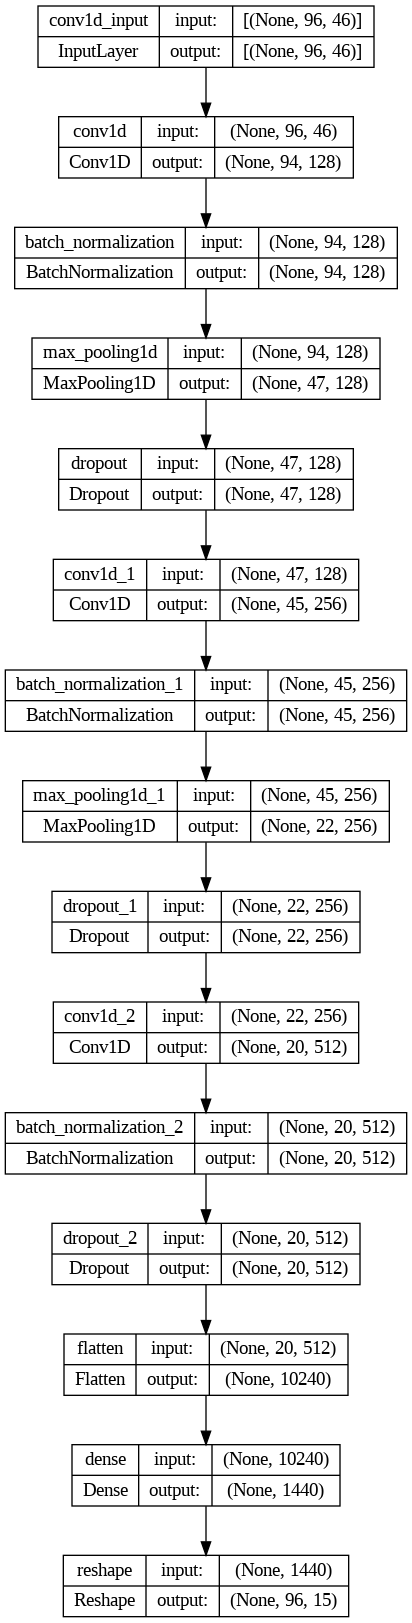

In [ ]:
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
epochs=1
history,  total_time= start_learning (model,train_gen,val_gen, epochs=epochs,batch_size=batch_size, full_history=None,ShowSummary=False)

12695/12695 [==============================] - 843s 66ms/step - loss: 0.3316 - accuracy: 0.8926 - val_loss: 0.3660 - val_accuracy: 0.8743
843.2857832969999


In [ ]:
#Подготовим тестовые данные
df_2308=pd.read_csv('/content/drive/MyDrive/internship/karate/dataset_alia/CSV/dataset__test_all_features_phase.csv')
df_2308=prepare_df(df_2308)

In [ ]:
#Тестирование
TestAccuracy,Total_y_true,Total_y_pred=evaluate_test(model,df_2308)

Удар ГЕДАН БАРАЙ,  для файла ГЕДАН БАРАЙ_20230814_171314 из 1273  правильно предсказано 1151 кадров => 90.42%
Удар ГЕДАН БАРАЙ,  для файла ГЕДАН БАРАЙ_20230814_171314_flip из 1273  правильно предсказано 1132 кадров => 88.92%
Удар ГЕДАН БАРАЙ,  для файла ГЕДАН БАРАЙ_20230814_171717 из 1281  правильно предсказано 1034 кадров => 80.72%
Удар ГЕДАН БАРАЙ,  для файла ГЕДАН БАРАЙ_20230814_171717_flip из 1281  правильно предсказано 1010 кадров => 78.84%
Удар ГЕДАН БАРАЙ,  для файла ГЕДАН БАРАЙ_не верный замах из 1242  правильно предсказано 950 кадров => 76.49%
Удар ГЕДАН БАРАЙ,  для файла ГЕДАН БАРАЙ_не верный замах 2 из 1398  правильно предсказано 1061 кадров => 75.89%
Удар ГЕДАН БАРАЙ,  для файла ГЕДАН БАРАЙ_не верный замах 2_flip из 1398  правильно предсказано 1099 кадров => 78.61%
Удар ГЕДАН БАРАЙ,  для файла ГЕДАН БАРАЙ_не верный замах_flip из 1242  правильно предсказано 945 кадров => 76.09%
Удар МАВАШИ ГЕРИ,  для файла МАВАШИ ГЕРИ_20230816_170111 из 1579  правильно пр

#Сохранение результатов в журнал

##Подключение к БД

In [ ]:
sys.path.append('/content/drive/MyDrive/internship/karate/dataset_alia/Journal')

In [ ]:
from KarateExperimentJournal import DBManager, JournalManager

In [ ]:
JManager=JournalManager('/content/drive/MyDrive/internship/karate/DB/karate_db.sqlite')

##Сохранение

In [ ]:
#Сохраняем результаты эксперимента
NetType='Conv1D'
NetName='3Conv_128_256_512'
NetDescription=' одномерных свертки (128,256,512) через MaxPooling1D (pool_size=2) и Dropout(0.2) BatchNormalization после каждой свертки'
BaseNet=''
LearningRate=K.get_value(model.optimizer.learning_rate)
Author='Матвеев'
epoch=len(history.history['loss'])
TimePerEpoch=total_time//epochs
Comment=''

ExperimentId =JManager.save_experiment(NetType=NetType,NetName=NetName,NetDescription=NetDescription,BaseNet=BaseNet,
BatchSize=batch_size,Epoch=epochs,LearningRate=LearningRate,
WinLen=win_len,
Step=step,
SpeedRatios=str(speed_ratios),
SmoothWin=smooth_win,
AddSpeed=int(add_speed),
DiscretSpeed=int(discret_speed),
DiscretSpeedThreshold=discret_speed_threshold,
PShift=p_shift,
StanceWeights=stance_weight,
OtherWeights=other_weight,
TimePerEpoch=TimePerEpoch,
TestLoss=0,TestMetric=TestAccuracy,
Comment=Comment,
Author=Author,
SeparateZamah=int(separate_zamah)
)

if ExperimentId is not None and history is not None:
    JManager.save_history(ExperimentId,history.history)
print (f'Создана новая запись эксперимента ID={ExperimentId}')

Создана новая запись эксперимента ID=44


In [ ]:
#model.save(os.path.join(ModelSavePath, NetName)) # Сохраняем модель

In [ ]:
#model=load_model(os.path.join(ModelSavePath, NetName)) # Загружаем сохраненную модель

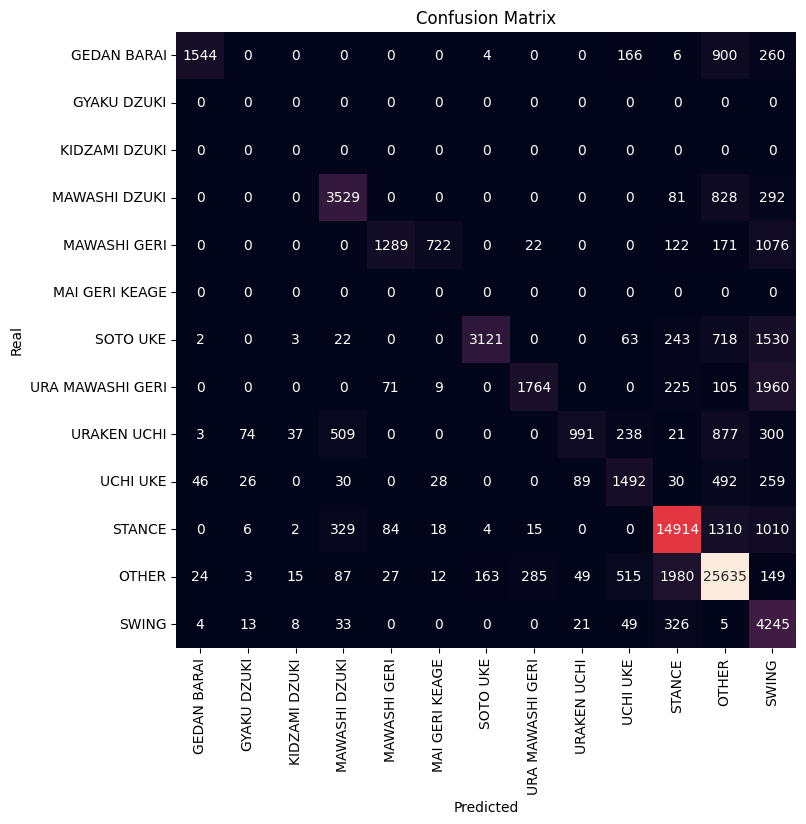

In [ ]:
show_confusion_matrix(Total_y_true,Total_y_pred)

In [ ]:
from google.colab import runtime
runtime.unassign()